In [1]:
master_path ='..\..\Raw_Data\\Bioreactor_Data\\\Leakage and efficiency'

In [2]:
from lib.tools import *

In [3]:
#Function for loading raw cytometry data

def guavafilename2datetime(fname):
    yr = int(fname.split('-')[0])
    mo = int(fname.split('-')[1])
    dy = int(fname.split('-')[2].split('_')[0])
    hr = int(fname.split('_')[-1].split('-')[0])
    mn = int(fname.split('_')[-1].split('-')[1])
    sec = int(fname.split('_')[-1].split('-')[2][:2])
    if 'pm' in fname:
        if hr < 12:
            hr += 12
    if 'am' in fname and hr == 12:
        hr = 0
    d = datetime(yr,mo,dy,hr,mn,sec)
    print(d)
    return d

def gather_fcs3_files(path):
    fcs3_files = []
    for root,dirs,files in os.walk(path):
        for f in files:
            if f.endswith('.fcs') or f.endswith('.fcs'):
                fpath = os.path.join(root,f)
                d = guavafilename2datetime(f)
                fcs3_files.append((root, f, d))
    return fcs3_files

def filter_fcs_based_on_date(fcs3_files, date_0, delta_t_hrs = 24):
    fcs3_datasets = []
    for root,f,d in fcs3_files:
        print(str(date_0) + ' -- ' + str(d))
        if d > date_0 and (d-date_0).total_seconds()/3600. < delta_t_hrs:
            fcs3_datasets.append(GuavaFCS3(os.path.join(root,f), only_meta=True))
    return fcs3_datasets
class GuavaFCS3:
    def __init__(self, guava_fcs3_file_path, only_meta=False):
        self.raw_file_path = guava_fcs3_file_path
        # parse metadata only, check if correct fcs 3.0 file, extract settings
        self.raw_metadata = fcsparsing.parse(self.raw_file_path, meta_data_only=True, reformat_meta=True)
        datetime_str_base = self.raw_metadata['$DATE'].strip() + ' ' + self.raw_metadata['$BTIM'].strip()
        for mon_str,mon_num in month_mapping.items():
            datetime_str_base = datetime_str_base.replace(mon_str,mon_num)
        self.datetime = datetime.strptime(datetime_str_base, '%d-%m-%Y %H:%M:%S')
        # check format
        if self.raw_metadata['__header__']['FCS format'] != b'FCS3.0':
            raise Exception('This is not a FCS3.0 file ?')
        self.settings = GuavaSettings(self.raw_metadata)
        # count the number of samples (and gather the wells)
        self.samples = {}
        self.samples_dataset_index = {}
        self.find_samples()
        # parse each sample data
        if not only_meta:
            for well in self.samples:
                self.get_sample(well)
    @property
    def sample_number(self):
        return len(self.samples)
    def get_sample(self, well):
        if self.samples[well] is None:
            meta,data = fcsparsing.parse(self.raw_file_path, data_set=self.samples_dataset_index[well], reformat_meta=True)
            self.samples[well] = GuavaSampleFCS3(meta, data, self.settings)
        return self.samples[well]
    def find_samples(self):
        i = 0
        while True:
            meta = fcsparsing.parse(self.raw_file_path, data_set=i, meta_data_only=True)
            if remove_0_well_id(meta['$WELLID']) not in self.samples:
                self.samples[remove_0_well_id(meta['$WELLID'])] = None
                self.samples_dataset_index[remove_0_well_id(meta['$WELLID'])] = i
                i += 1
            else:
                break
    def __repr__(self):
        wells = ', '.join([str(w) for w in list(self.samples.keys())])
        return f'fcs3 dataset, {self.datetime}, {self.sample_number} samples ({wells})'

class GuavaSampleFCS3:
    def __init__(self, meta, data, settings):
        self.raw_metadata = meta
        self.raw_data = data
        self.settings = settings
        self.date = self.raw_metadata['$DATE'].strip()
        self.sample_id = self.raw_metadata['GTI$SAMPLEID']
        self.well_id = self.raw_metadata['$WELLID']
        self.start_time = self.raw_metadata['$BTIM'].strip()
        self.end_time = self.raw_metadata['$ETIM'].strip()
        datetime_str_base = self.date + ' ' + self.start_time
        for mon_str,mon_num in month_mapping.items():
            datetime_str_base = datetime_str_base.replace(mon_str,mon_num)
        self.start_datetime = datetime.strptime(datetime_str_base, '%d-%m-%Y %H:%M:%S')
        self.raw_data.rename(index=str, columns={colname:colname.split('(')[1].split(')')[0] for colname in self.raw_data.columns if '(' in colname}, inplace=True)
    def to_df(self, reactor_id=None, timepoint_id=None, compute_gating_metric=False, compute_doublet_metric=False, min_n_return_none=100):
        df = self.raw_data.copy()
        if len(df) < min_n_return_none:
            print('too few events in the sample, returning None')
            return None
        # compute the event concentration per uL
        timestep_s = float(self.raw_metadata['$TIMESTEP'])
        pump_speed_factor = float(self.raw_metadata['GTI$PUMPSAMPLESPEED'])
        flow_rate_ref_uL_per_s = float(self.raw_metadata['GTI$FLOWRATECAL'])
        flow_rate_uL_per_s = pump_speed_factor * flow_rate_ref_uL_per_s
        dt_s = (df['Time'].iloc[-1] - df['Time'].iloc[0]) * timestep_s
        vol_uL = dt_s * flow_rate_uL_per_s
        dn = len(df)
        conc_per_uL = dn / vol_uL
        df['cells_per_uL'] = conc_per_uL
        # add some columns: time, reactor, gating metric...
        df['time_s'] = self.start_datetime.timestamp()
        if reactor_id:
            df['reactor_id'] = reactor_id
        if timepoint_id is not None:
            df['timepoint_id'] = timepoint_id
        if compute_gating_metric:
            df = gating.compute_ks_FSC_SSC_gating_metric(df)
        if compute_doublet_metric:
            df = gating.compute_doublet_metric(df)
        return df
    def to_csv(self, filepath, reactor_id=None, timepoint_id=None, compute_gating_metric=False, compute_doublet_metric=False):
        output_data = self.to_df(reactor_id, timepoint_id, compute_gating_metric, compute_doublet_metric)
        output_data.to_csv(filepath, index=False)

def filter_fcs_based_on_date(fcs3_files, date_0, delta_t_hrs = 24):
    fcs3_datasets = []
    for root,f,d in fcs3_files:
        print(str(date_0) + ' -- ' + str(d))
        if d > date_0 and (d-date_0).total_seconds()/3600. < delta_t_hrs:
            fcs3_datasets.append(GuavaFCS3(os.path.join(root,f), only_meta=True))
    return fcs3_datasets

class GuavaSettings:
    # store what matters: gain and other acquisition settings
    # helper method to check same setting
    # maybe put there the method to correct for different gain
    def __init__(self, metadata):
        self.raw_metadata = metadata
        self.channels = {}
        for _,ch in self.raw_metadata['_channels_'].iterrows():
            self.channels[ch['$PnN']] = ch.to_dict()
def remove_0_well_id(with_0):
    return with_0[0] + str(int(with_0[1:]))

In [4]:
# functions for treating raw cytometry data

def get_sample(basepath= False):
    if basepath == False:
        Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
        basepath =filedialog.askdirectory() # show an "Open" dialog box and return the path to the selected file
    print(basepath)
    thresh1=0.2
    thresh2=0.5
    thresh3=3
    master_d = defaultdict(dict)
    n_tp = 0
    time_abs = []
    time_vec = []
    for fname in os.listdir(basepath):
        path = os.path.join(basepath, fname)
        if os.path.isdir(path):
            if fname[-2:] == 'am':
                print(path)
                n_tp += 1
                d = guavafilename2datetime(fname)
                yr = int(fname[0:4])
                mo = int(fname[5:7])
                dias = int(fname[8:10])
                t_0 = datetime(yr,mo,dias)
                
                hr = int(fname[14:16])
                mins = int(fname[17:19])
                t = datetime(yr,mo,dias,hr,mins)
            elif fname[-2:] == 'pm':
                n_tp += 1
                d = guavafilename2datetime(fname)
                yr = int(fname[0:4])
                mo = int(fname[5:7])
                dias = int(fname[8:10])
                t_0 = datetime(yr,mo,dias)
                if int(fname[14:16]) ==12:
                    hr = int(fname[14:16])
                else:
                    hr = int(fname[14:16]) +12
                mins = int(fname[17:19])
                t = datetime(yr,mo,dias,hr,mins)

            else:
                continue
                    
            fcs3_files = []
            fcs3_files =gather_fcs3_files(path)

            fcs3_datasets = filter_fcs_based_on_date(fcs3_files, t_0, delta_t_hrs = 36500000000)
            slot_data = {}
            num_sample = len(fcs3_datasets) 
        
            for jj in range(num_sample):
                k = fcs3_datasets[jj].samples_dataset_index
                for well in k:
                    pf = well
                df = fcs3_datasets[jj].get_sample(pf).to_df()
                slot_data[pf] = df
            def rename_keys(d, keys):
        
                return dict([(keys.get(k), v) for k, v in d.items()])
            translation = {}
            for zz in slot_data.keys():
                if len(zz)<3:
                    print(zz)
                    translation[zz] = str(zz[0]+'0'+zz[1])
                else:
                    translation[zz] = zz
            trans_slot = rename_keys(slot_data, translation)
            sorted_slot = dict( sorted(trans_slot.items()) )
            sorted_sing = get_singlets(sorted_slot, thresh1,thresh2,thresh3)
            time_abs.append(t)
            time_vec.append((t-time_abs[0]).total_seconds()/60)
            master_d[time_vec[-1]] = sorted_sing
            master_d = dict(sorted(master_d.items()))
    return(master_d)
    




def get_singlets(slot_data, thresh1, thresh2, thresh3, plots ='False'):
    gated_slot_data = {}
    singlet_slot_data= {}
    for w in slot_data.keys():
        if (slot_data[w] is not  None) and (len(slot_data[w])>500):
                data1 = []
                data2 = []
                gated_slot_data[w] = compute_ks_FSC_SSC_gating_metric(slot_data[w], grid_size=100)
                singlet_slot_data[w] = compute_doublet_metric(gated_slot_data[w])
                data1 = singlet_slot_data[w].loc[(singlet_slot_data[w]['gating-metric'] >=thresh1)]
                data2 = data1.loc[(data1['doublet-metric'] <= thresh2)] 
                print('Gating is done for')
                print(w)
                if plots == 'True':
                    figure, ax1 = plt.subplots(figsize=(5, 5), dpi=200, facecolor='w', edgecolor='k')
                    ax1.scatter(slot_data[w]['FSC-HLin'],slot_data[w]['SSC-HLin'], s = 0.1, color = 'red',label='Raw_Data')
                    ax1.scatter(data1['FSC-HLin'],data1['SSC-HLin'], s = 0.1, color = 'yellow',label='Size_Gated_Data')
                    ax1.scatter(data2['FSC-HLin'],data2['SSC-HLin'], s = 0.1, color = 'green',label='Singlets')
                    #ax1.scatter(slot_data[w]['FSC-HLin'],slot_data[w]['SSC-HLin'], s = 0.1, color = 'red')
                    plt.yscale('log')
                    plt.xscale('log')    
                    ax1.set_xlim([1,100000])
                    ax1.set_ylim([1,100000])
                    ax1.set_xlabel('FSCH')
                    ax1.set_ylabel('SSCH', color='black')
                    ax1.legend()
                    ax1.set_title(fname + ' FSCH vs SSCH %s' % w )
                    plt.savefig(fname + ' FSCH vs SSCH %s'   % (w)+'.png')
                        
                    figure, ax1 = plt.subplots(figsize=(5, 5), dpi=200, facecolor='w', edgecolor='k')
                    ax1.scatter(slot_data[w]['FSC-HLin'],slot_data[w]['FSC-ALin'], s = 0.1, color = 'red',label='Raw_Data')
                    ax1.scatter(data1['FSC-HLin'],data1['FSC-ALin'], s = 0.1, color = 'yellow',label='Size_Gated_Data')
                    ax1.scatter(data2['FSC-HLin'],data2['FSC-ALin'], s = 0.1, color = 'green',label='Singlets')
                    #ax1.scatter(slot_data[w]['FSC-HLin'],slot_data[w]['SSC-HLin'], s = 0.1, color = 'red')
                    plt.yscale('log')
                    plt.xscale('log')
                    ax1.set_xlim([1,100000])
                    ax1.set_ylim([1,100000])
                    ax1.set_xlabel('FSCH')
                    ax1.set_ylabel('FSCA', color='black')
                    ax1.legend()
                    ax1.set_title(fname + ' FSCH vs FSCA %s' % w )
                                 
        else:
            print('Not enough cells yo read Kafka') 
            print(w)
            try: #adding zeros for the gating of timepoints that were erroneous and didn't acquire enough events
                dat1 = pd.DataFrame({'gating-metric': [int(float(0)) for x in range(len(slot_data[w]))]})
                dat2 = pd.DataFrame({'doublet-metric':[int(float(0)) for x in range(len(slot_data[w]))]})
                gated_slot_data[w] = slot_data[w].join(dat1)
                singlet_slot_data[w] = gated_slot_data[w].join(dat2)
            except:
                gated_slot_data[w] = slot_data[w]
                singlet_slot_data[w] = gated_slot_data[w]
                    
 #here we have the original single point data frame with two gating metrics that can be used to gate on size and remove doublets

        
    return singlet_slot_data


In [5]:
#This function computes the differentiated fraction for each well of each condition after size gating and removing aberrant cells
# master_d is the dictionary with all the data for each condition
# thresh_mc is the threshold above which a cell is deemed fluorescent in mCerulean channel
# thesh_mn is the threshold above which a cell is deemed fluorescent in mNeonGreen channel
# If stats =True, the number of events acquired for each well, 
#                 size gated population % of total, 
#                 singlets % size gated,
#                 and viable cells % of singlets 
# are printed 
def colony_checker(master_d, thresh_mn,thresh_mc,stats = False,plots = False):
    rec_fr = defaultdict(dict)

    for key,value in master_d.items():
        jj = 0
        for well, data in value.items():
            print(well)
            data = infer_FP_amounts(data, AF, FP_signatures)
            sz = data.loc[(data['gating-metric'] >= thresh1)] #size gating
            db = sz.loc[(sz['doublet-metric'] <= thresh2)] #doublet removal
            d2 = db.loc[(db[chan1] >thresh_mc) | (db[chan2] >thresh_mn) ]#Removing aberrant cells
            rec = d2.loc[(d2[chan2]> thresh_mn)][chan1].count()/(d2[chan1].count())
            rec_fr[key][well] = rec
            labia = str(key) +' ' +well 

            jj+=1
            if stats == True:
                print('Total events acquired =  %d' %len(data) )
                size = 100*len(sz)/len(data)
                print('Size gated cells were %0.3f percent of the population' %size )
                sing = 100*len(db)/len(sz)
                print('Singlets were %0.3f percent of the size gated population' %sing )
                viable = 100*len(d2)/len(db)
                print('Viable cells were %0.3f percent of the singlets' %viable )
                recs=rec*100
                print('Of the viable cells %0.3f percent were differentiated' %recs )

    if plots == True:
        
        for data in rec_fr.values():
            xx = 0
            fig, (ax1) = plt.subplots(1,1, figsize=(12, 3),dpi=100, facecolor='w', edgecolor='k')
            cuz = []
            for colonies in data.values():
                if xx%2 ==0:
                    col = 'b'
                    ax1.scatter(xx,colonies*100,color = col,s = 20)
                else:
                    col = 'grey'
                    ax1.scatter(xx,colonies*100,color = col,s = 20)
                cuz.append(colonies*100)
                xx+=1
        means = np.mean(np.asarray(cuz))
        ax1.axhline(y = means, color ='r',label  = 'Mean = %0.3f' %means)
        ax1.set_title(cond)
        ax1.set_xticks([i for i in range(xx)])
        ax1.set_xticklabels([i for i in  data.keys()])
        ax1.grid(True)
        ax1.set_ylabel('Fraction Differentiated(%)')
        ax1.set_xlabel('Well')
        ax1.legend(loc = 'upper right')
    return(rec_fr)

In [6]:
def scatterbars(ax,ind,data,color,edgecolor,sz = 20,capsize = 10):
    scatterwidth = np.linspace(ind-0.3,ind+0.3, len(data))
    ax.bar(ind,np.mean(data),color =color,yerr =np.std(data),capsize = capsize)
    ax.scatter(scatterwidth,data,color =color,s =sz,edgecolor = edgecolor,lw = lw,zorder =10000 )

    return

def scatterwobars(ax,ind,data,color,edgecolor,sz = 20,capsize = 10):
    scatterwidth = np.linspace(ind-0.3,ind+0.3, len(data))
    ax.scatter(scatterwidth,data,color =color,s =sz,edgecolor = edgecolor,lw = lw,zorder =10000 )

    return

def woscatterbars(ax,ind,data,color,edgecolor,sz = 20,capsize = 10):
    ax.bar(ind,np.mean(data),color =color,yerr =np.std(data)/np.sqrt(3),capsize = capsize)

    return 

def scatterbox(ax,ind,data,color,edgecolor,sz = 20,capsize = 10):
    scatterwidth = np.linspace(ind-0.4,ind+0.4, len(data))
    print(ind)
    print(data)
    bplot1 =ax.boxplot(data, whis=1.5, showfliers=False,positions = [ind],widths = [0.5],patch_artist=True)
    ax.scatter(scatterwidth,data,color =color,s =sz,edgecolor = edgecolor,lw = lw,zorder =10000 )

    for bplot in [bplot1]:
        for patch in bplot['boxes']:
            patch.set_edgecolor('w')
            patch.set_facecolor(color)
    return


Loading data might take a while, you might wanna run the other notebooks in the meantime.


In [7]:
month_mapping = {'JAN':'01', 'FEB':'02', 'MAR':'03', 'APR':'04', 'MAY':'05', 'JUN':'06',
                'JUL':'07', 'AUG':'08', 'SEP':'09', 'OCT':'10', 'NOV':'11', 'DEC':'12'}
conditions = ['0h','1h after 4h of light','exponential growth 24h after 4h of light','24h dark replicate1',
             '24h dark replicate2','72h dark replicate1','72h dark replicate2']
master_colony = defaultdict()
for folder in conditions:
    basepath = os.path.join(master_path,folder)
    print(folder)
    master_colony[folder] = get_sample(basepath)

0h
..\..\Raw_Data\Bioreactor_Data\\Leakage and efficiency\0h
..\..\Raw_Data\Bioreactor_Data\\Leakage and efficiency\0h\2021-03-18_at_11-47-32am
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 11:47:32
2021-03-18 00:00:00 -- 2021-03-18 11:47:32
2021-03-18 00:00:00 -- 2021-03-18 11:47:32
2021-03-18 00:00:00 -- 2021-03-18 11:47:32
2021-03-18 00:00:00 -- 2021-03-18 11:47:32
2021-03-18 00:00:00 -- 2021-03-18 11:47:32
2021-03-18 00:00:00 -- 2021-03-18 11:47:32
2021-03-18 00:00:00 -- 2021-03-18 11:47:32
2021-03-18 00:00:00 -- 2021-03-18 11:47:32
2021-03-18 00:00:00 -- 2021-03-18 11:47:32
2021-03-18 00:00:00 -- 2021-03-18 11:47:32
2021-0

A1
B2
C2
D2
E2
F2
G2
H2
A3
B3
C3
B1
D3
C1
D1
E1
F1
G1
H1
A2
Gating is done for
A01
Gating is done for
A02
Gating is done for
A03
Gating is done for
B01
Gating is done for
B02
Gating is done for
B03
Gating is done for
C01
Gating is done for
C02
Gating is done for
C03
Gating is done for
D01
Gating is done for
D02
Gating is done for
D03
Gating is done for
E01
Gating is done for
E02
Gating is done for
F01
Gating is done for
F02
Gating is done for
G01
Gating is done for
G02
Gating is done for
H01
Gating is done for
H02
72h dark replicate1
..\..\Raw_Data\Bioreactor_Data\\Leakage and efficiency\72h dark replicate1
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-03-21 14:42:23
2021-

******0h******
A03
Total events acquired =  50000
Size gated cells were 44.950 percent of the population
Singlets were 92.570 percent of the size gated population
Viable cells were 99.986 percent of the singlets
Of the viable cells 0.091 percent were differentiated
A04
Total events acquired =  50000
Size gated cells were 46.478 percent of the population
Singlets were 88.420 percent of the size gated population
Viable cells were 99.985 percent of the singlets
Of the viable cells 0.010 percent were differentiated
A05
Total events acquired =  50000
Size gated cells were 49.586 percent of the population
Singlets were 84.354 percent of the size gated population
Viable cells were 99.981 percent of the singlets
Of the viable cells 0.043 percent were differentiated
B03
Total events acquired =  50000
Size gated cells were 53.562 percent of the population
Singlets were 75.266 percent of the size gated population
Viable cells were 99.985 percent of the singlets
Of the viable cells 0.055 percent w

Total events acquired =  50000
Size gated cells were 42.428 percent of the population
Singlets were 92.463 percent of the size gated population
Viable cells were 100.000 percent of the singlets
Of the viable cells 99.047 percent were differentiated
G01
Total events acquired =  50000
Size gated cells were 43.554 percent of the population
Singlets were 94.503 percent of the size gated population
Viable cells were 99.995 percent of the singlets
Of the viable cells 98.984 percent were differentiated
G02
Total events acquired =  50000
Size gated cells were 40.050 percent of the population
Singlets were 93.948 percent of the size gated population
Viable cells were 100.000 percent of the singlets
Of the viable cells 98.979 percent were differentiated
H01
Total events acquired =  50000
Size gated cells were 49.342 percent of the population
Singlets were 87.394 percent of the size gated population
Viable cells were 100.000 percent of the singlets
Of the viable cells 99.207 percent were differen

Total events acquired =  50000
Size gated cells were 41.238 percent of the population
Singlets were 90.053 percent of the size gated population
Viable cells were 99.876 percent of the singlets
Of the viable cells 0.038 percent were differentiated
D02
Total events acquired =  50000
Size gated cells were 45.834 percent of the population
Singlets were 83.929 percent of the size gated population
Viable cells were 99.870 percent of the singlets
Of the viable cells 0.010 percent were differentiated
D03
Total events acquired =  50000
Size gated cells were 43.340 percent of the population
Singlets were 88.929 percent of the size gated population
Viable cells were 99.933 percent of the singlets
Of the viable cells 0.036 percent were differentiated
E01
Total events acquired =  50000
Size gated cells were 40.374 percent of the population
Singlets were 91.841 percent of the size gated population
Viable cells were 99.995 percent of the singlets
Of the viable cells 0.049 percent were differentiated


Viable cells were 100.000 percent of the singlets
Of the viable cells 0.056 percent were differentiated
C01
Total events acquired =  50000
Size gated cells were 40.972 percent of the population
Singlets were 95.426 percent of the size gated population
Viable cells were 99.995 percent of the singlets
Of the viable cells 0.118 percent were differentiated
C02
Total events acquired =  47425
Size gated cells were 40.536 percent of the population
Singlets were 96.390 percent of the size gated population
Viable cells were 99.978 percent of the singlets
Of the viable cells 0.086 percent were differentiated
C03
Total events acquired =  50000
Size gated cells were 41.874 percent of the population
Singlets were 95.458 percent of the size gated population
Viable cells were 99.995 percent of the singlets
Of the viable cells 0.115 percent were differentiated
D01
Total events acquired =  50000
Size gated cells were 39.194 percent of the population
Singlets were 95.535 percent of the size gated popula

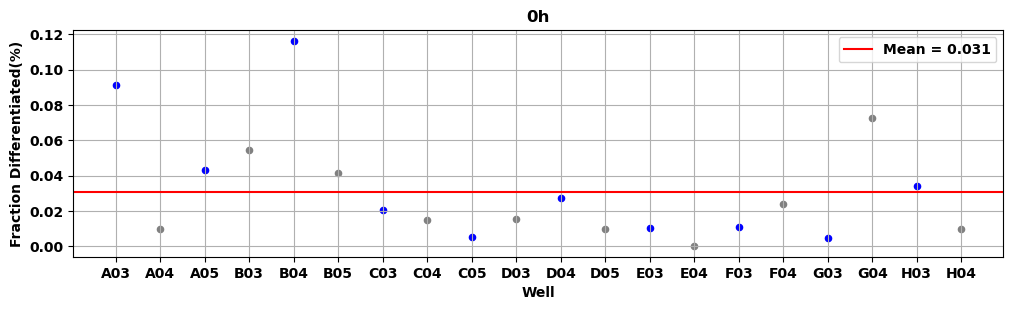

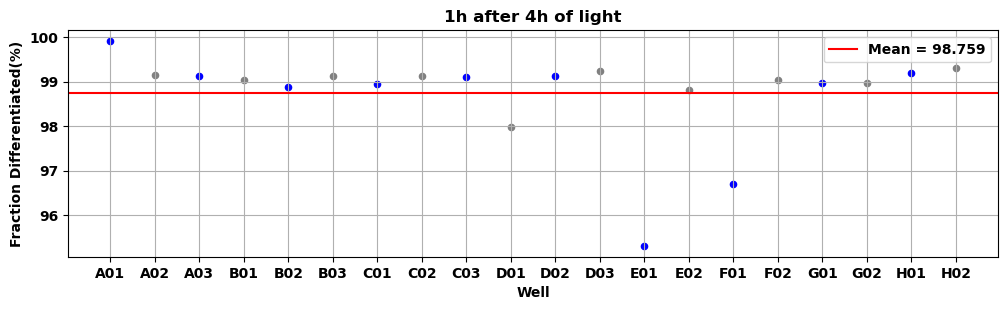

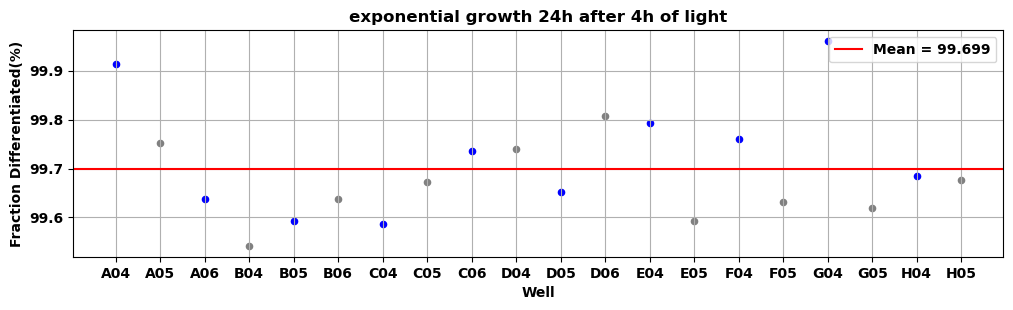

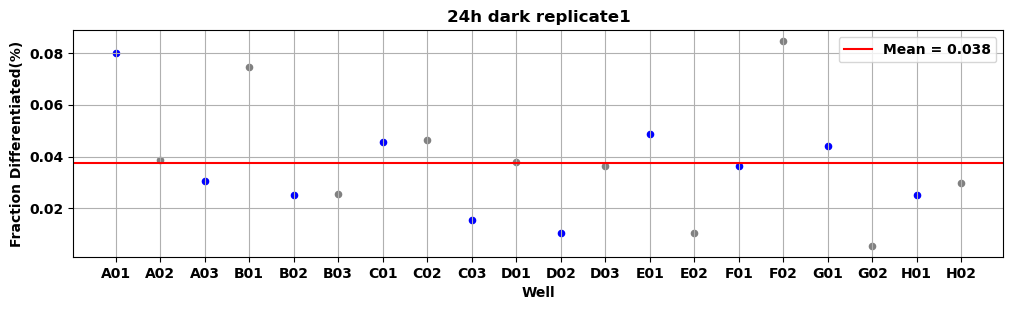

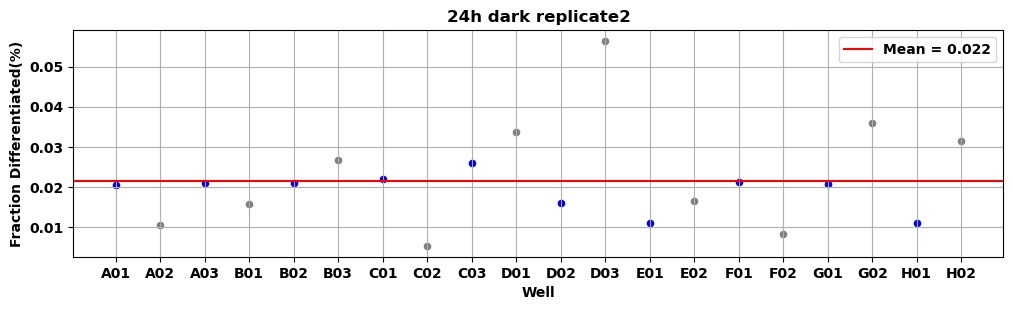

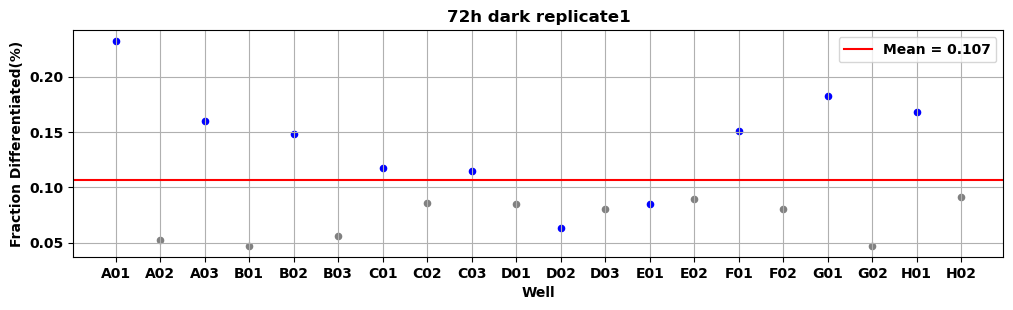

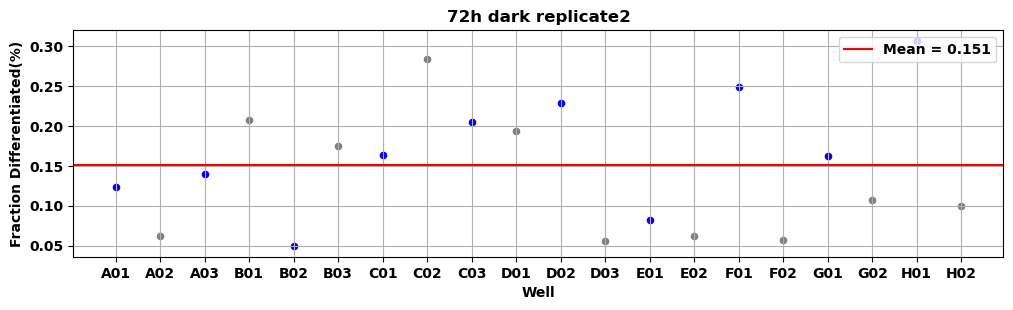

In [8]:
thresh_mn = 200
thresh_mc = 10
thresh1=0.5
thresh2=0.5
chan1 = 'GRN-V-HLin'
chan2 = 'GRN-B-HLin'
#     chan1 = 'mCerulean'
#     chan2 = 'mNeonGreen'
fractions = defaultdict()
for cond in master_colony.keys():
    print('******' + cond + '******')
    fractions[cond]= colony_checker(master_colony[cond], thresh_mn,thresh_mc, stats =True,plots= True)

In [9]:
fractions_array = {}
conditions = ['0h','l1','l24','24h d1',
             '24h d2','72h d1','72h d2']
for jj,darky in enumerate(fractions.values()):
    for da in darky.values():
        mona = []
        for d in da.values():
            mona.append(d) 
        mona = np.asarray(mona)*100
        fractions_array[conditions[jj]] = mona
       

In [10]:
fractions_array

{'0h': array([0.09133737, 0.00973473, 0.04304161, 0.05457974, 0.11654468,
        0.04155628, 0.02041858, 0.01469076, 0.00509035, 0.01527262,
        0.02764264, 0.01001803, 0.01020564, 0.        , 0.01101625,
        0.02404771, 0.00459812, 0.07293946, 0.03419471, 0.00982608]),
 'l1': array([99.92996109, 99.14374937, 99.12863266, 99.04577448, 98.89072103,
        99.13025683, 98.94305019, 99.13238747, 99.10747293, 97.99346495,
        99.13840413, 99.23612555, 95.29619216, 98.82478632, 96.70696325,
        99.04664797, 98.98440157, 98.97942912, 99.20690135, 99.31034483]),
 'l24': array([99.91432855, 99.75172155, 99.63712283, 99.54083306, 99.59203369,
        99.63876095, 99.58660975, 99.67190063, 99.73617135, 99.73928158,
        99.65303141, 99.80659422, 99.79360165, 99.59307804, 99.76029963,
        99.6307138 , 99.9615791 , 99.61859789, 99.68452857, 99.67570072]),
 '24h d1': array([0.08018817, 0.03851444, 0.030409  , 0.07482416, 0.0249975 ,
        0.02567658, 0.0457108 , 0.0462701

In [11]:
d_0 = fractions_array['0h']

d1_24 = fractions_array['24h d1'] #technical replicate 1
d2_24 = fractions_array['24h d2'] #technical replicate 2
d_24 = (d1_24 +np.flip(d2_24))/2 # mean, tr2 was flipped because the samples were acquired in the reverse ordered to average effects due to time spent in the cytometer
d1_72 = fractions_array['72h d1'] #technical replicate 1
d2_72 = fractions_array['72h d2'] #technical replicate 2
d_72 = (d1_72 +np.flip(d2_72))/2 # mean, tr2 was flipped because the samples were acquired in the reverse ordered to average effects due to time spent in the cytometer
l1 = fractions_array['l1'] # values 1h after 4h induction
l24 = fractions_array['l24'] # values 24h after 4h induction in exponential phase

<ipython-input-12-2bf35916ff0b>:78: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


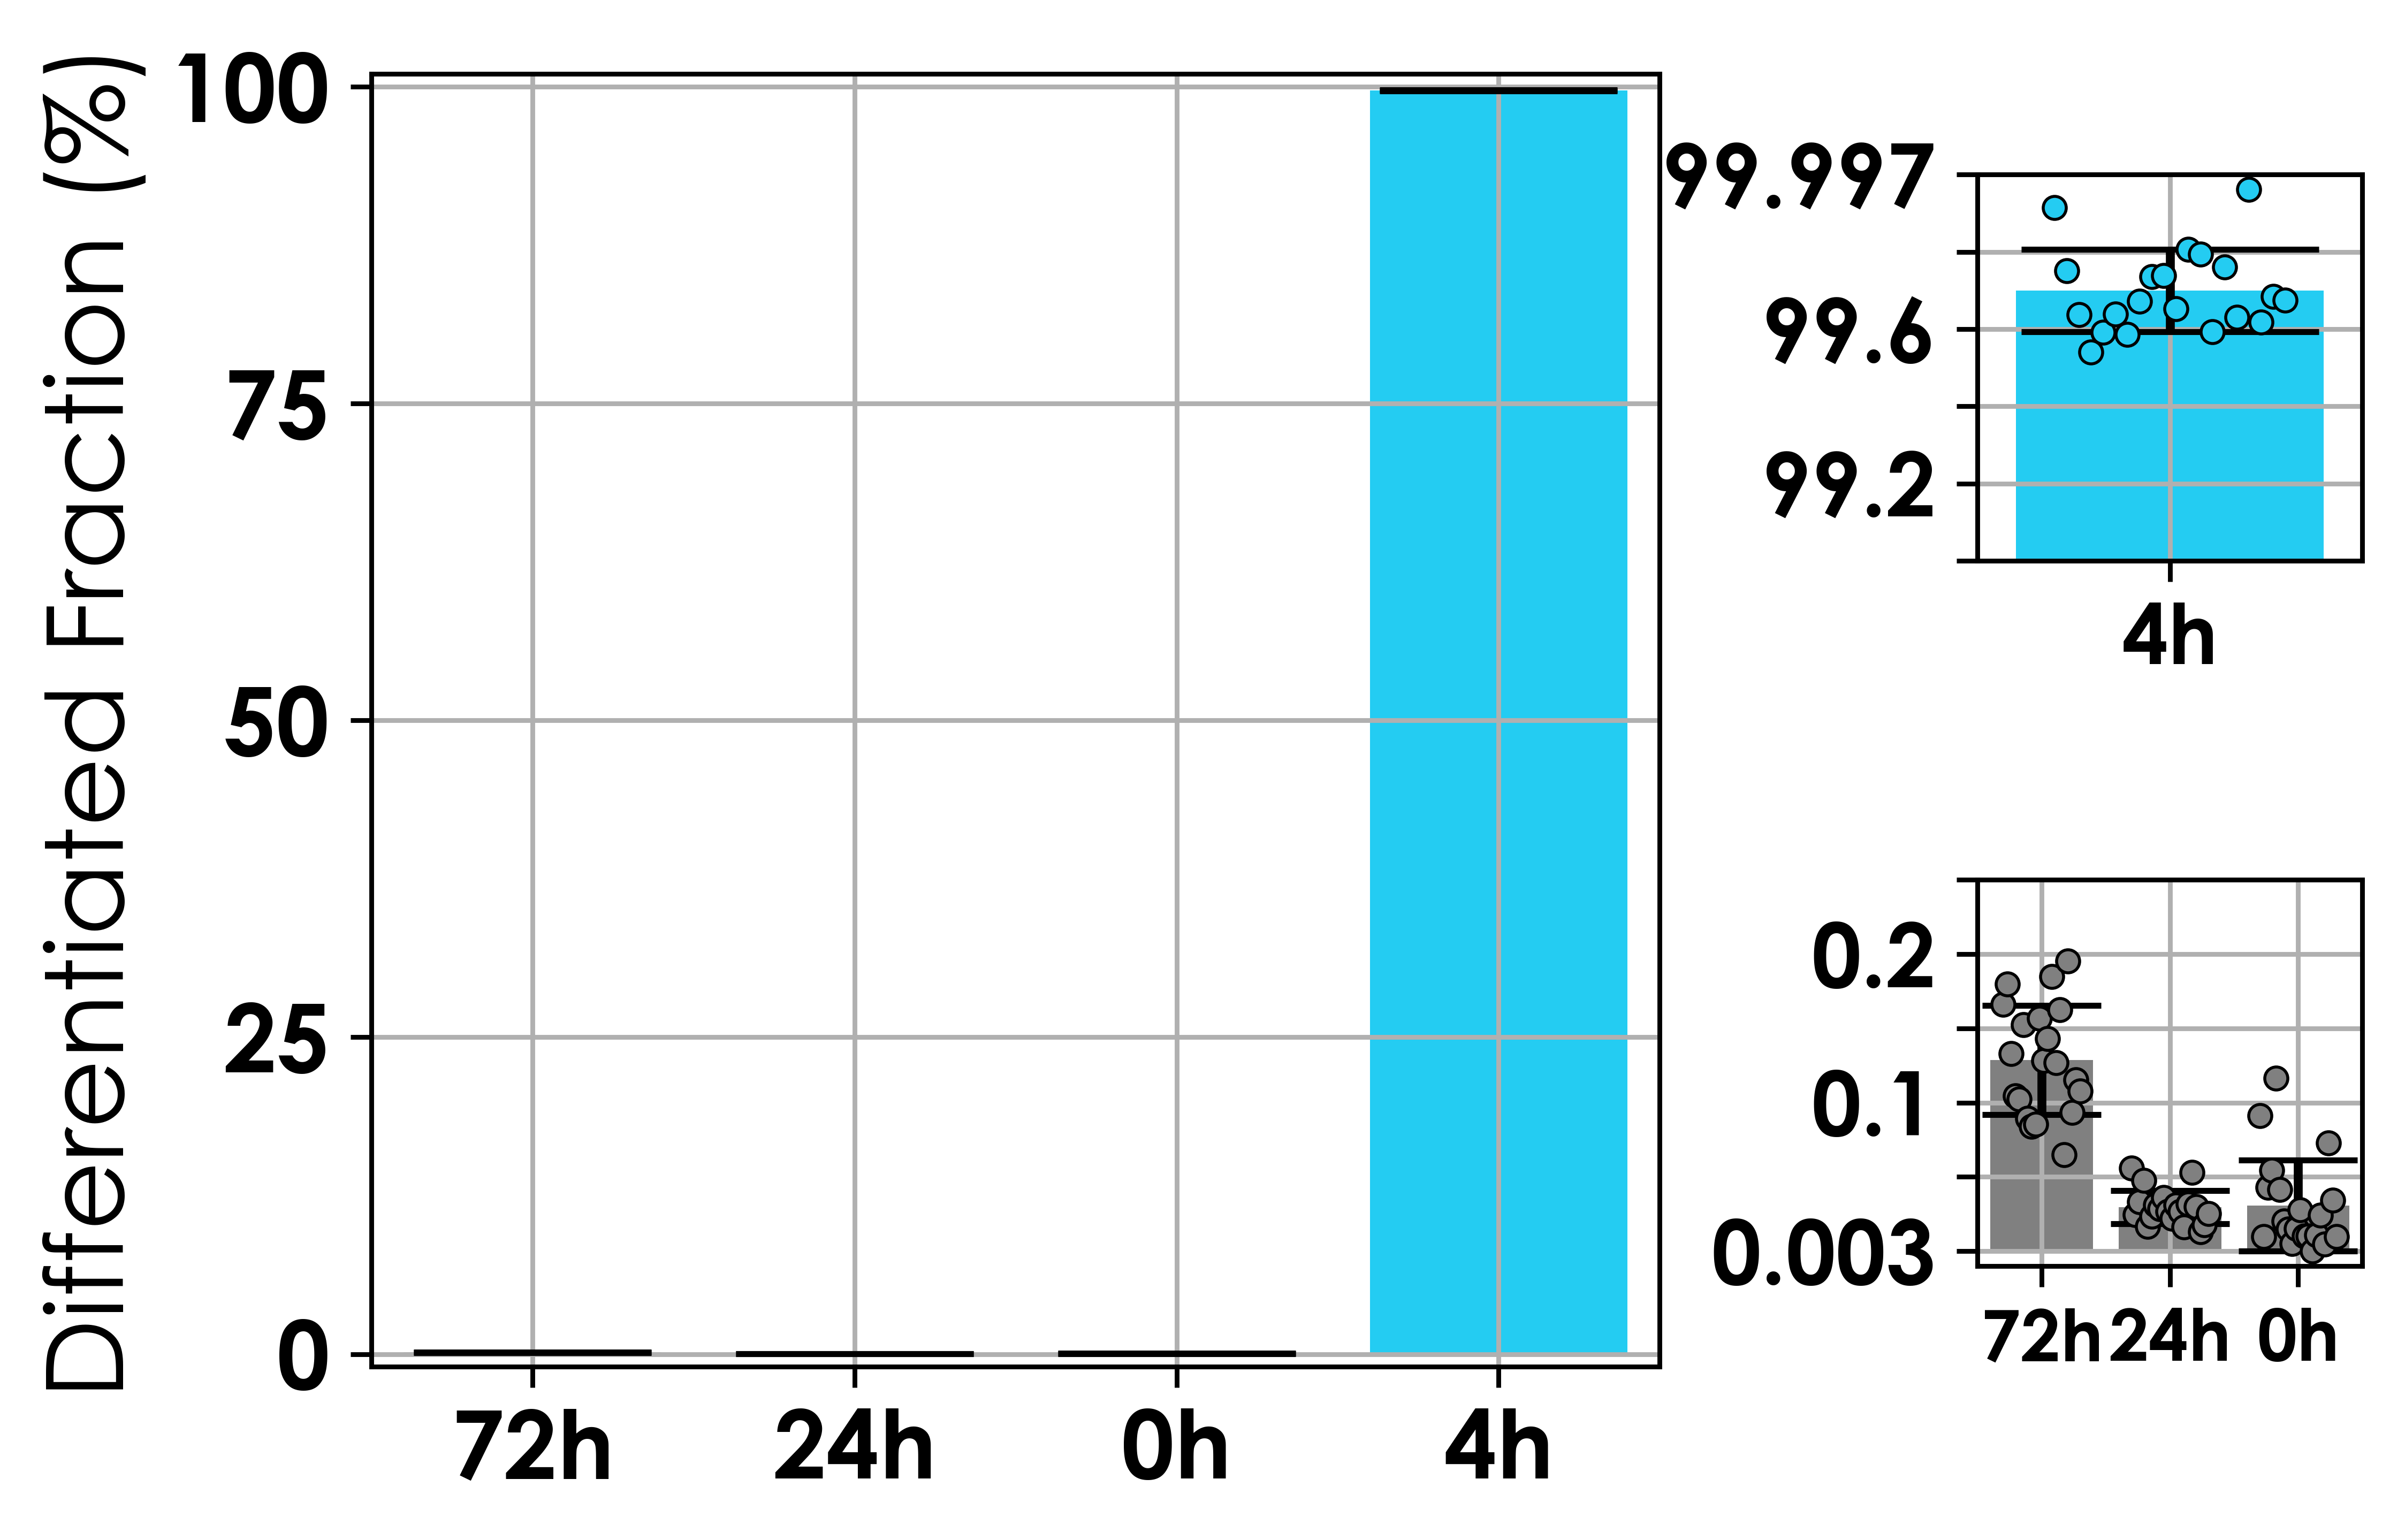

In [12]:
sz=30
capsize = 20
lw =0.5
fs = 18
col_d = '#808080'
col_l = '#24ccf2'
col_72 ='#454545'
col_24 = '#f2420c'
col_li ='k'
import matplotlib.gridspec as gridspec
axes = plt.figure(constrained_layout=False,figsize = (6,4),dpi=800).subplot_mosaic(
                [['M', 'M', 'M', 'M','M','M', 'M','M','M','M', 'M','M','M','.','.','.','.','.','.','.'],
                 ['M', 'M', 'M', 'M','M','M', 'M','M','M','M', 'M','M','M','.','.','.','I1','I1','I1','I1'],
                 ['M', 'M', 'M', 'M','M','M', 'M','M','M','M', 'M','M','M','.','.','.','I1','I1','I1','I1'],
                 ['M', 'M', 'M', 'M','M','M', 'M','M','M','M', 'M','M','M','.','.','.','I1','I1','I1','I1'],
                 ['M', 'M','M', 'M', 'M','M', 'M','M','M','M', 'M','M','M','.','.','.','I1','I1','I1','I1'],
                 ['M', 'M','M', 'M', 'M','M', 'M','M','M','M', 'M','M','M','.','.','.','.','.','.','.'],
                 ['M', 'M','M', 'M', 'M','M', 'M','M','M','M', 'M','M','M','.','.','.','.','.','.','.'],
                 ['M', 'M','M', 'M', 'M','M', 'M','M','M','M', 'M','M','M','.','.','.','.','.','.','.'],
                 ['M', 'M','M', 'M', 'M','M', 'M','M','M','M', 'M','M','M','.','.','.','I2','I2','I2','I2'],
                 ['M', 'M','M', 'M', 'M','M', 'M','M','M','M', 'M','M','M','.','.','.','I2','I2','I2','I2'],
                 ['M', 'M','M', 'M', 'M','M', 'M','M','M','M', 'M','M','M','.','.','.','I2','I2','I2','I2'],
                 ['M', 'M','M', 'M', 'M','M', 'M','M','M','M', 'M','M','M','.','.','.','I2','I2','I2','I2'],
                 ['M', 'M','M', 'M', 'M','M', 'M','M','M','M', 'M','M','M','.','.','.','.','.','.','.']])
ax1 = axes['M']
ax2 = axes['I2']
ax3 = axes['I1']

woscatterbars(ax1,1,d_72 ,col_d,col_li,sz = sz,capsize = capsize) 

woscatterbars(ax1,2,d_24 ,col_d,col_li,sz = sz,capsize = capsize)

woscatterbars(ax1,3,d_0 ,col_d,col_li,sz = sz,capsize = capsize)

woscatterbars(ax1,4,l24 ,col_l,col_li,sz = sz,capsize = capsize)

ax1.set_xticks((1,2,3,4)) 
ax1.set_xticklabels(('72h', '24h', '0h','4h'), fontsize=fs-2,**cgfont)
ax1.set_yticks((0,25,50,75,100)) 
ax1.set_yticklabels(('0', '25', '50','75','100'), fontsize=fs-2,**cgfont)

ax1.set_ylim(-1,101)
ax1.set_xlim(0.5,4.5)
ax1.grid()
ax1.set_ylabel('Differentiated Fraction (%)', fontsize=fs,**cgfont)
sz2=15
capsize = 10
lw =0.5

scatterbars(ax2,3,d_0 ,col_d,col_li,sz = sz2,capsize = capsize)
scatterbars(ax2,1,d_72 ,col_d,col_li,sz = sz2,capsize = capsize)
scatterbars(ax2,2,d_24 ,col_d,col_li,sz = sz2,capsize = capsize)
scatterbars(ax2,4,l24 ,col_l,col_li,sz = sz2,capsize = capsize)
ax2.set_xticks((1,2,3)) 
ax2.set_xticklabels(('72h', '24h', '0h'), fontsize=fs-6,**cgfont)
ax2.set_yticks((0,0.05,0.1,0.15,0.2,0.25)) 
ax2.set_yticklabels(('0.003', '', '0.1','','0.2',''), fontsize=fs-3,**cgfont)

ax2.set_ylim(-0.01,0.25)
ax2.set_xlim(0.5,3.5)
ax2.grid()


sz2=15
capsize = 25
lw =0.5
scatterbars(ax3,1,d_72 ,col_d,col_72,sz = sz2,capsize = capsize)
scatterbars(ax3,2,d_24 ,col_d,col_24,sz = sz2,capsize = capsize)
scatterbars(ax3,3,d_0 ,col_d,col_24,sz = sz2,capsize = capsize)
scatterbars(ax3,4,l24 ,col_l,col_li,sz = sz2,capsize = capsize)
ax3.set_xticks([4])
ax3.set_xticklabels(['4h'], fontsize=fs-4,**cgfont)
ax3.set_yticks((99,99.2,99.4,99.6,99.8,100)) 
ax3.set_yticklabels(('', '99.2', '','99.6','','99.997'), fontsize=fs-3,**cgfont)
ax3.set_ylim(99,100)
ax3.set_xlim(3.5,4.5)
ax3.grid()
plt.tight_layout()
plt.savefig('../plots' +'/Figure1c.eps',bbox_inches='tight')
plt.savefig('../plots' +'/Figure1c.png',bbox_inches='tight')
plt.savefig('../plots' +'/Figure1c.svg',bbox_inches='tight')

In [13]:
print('**Stats for DR dark behaviour- paired ttest')
t,juju = scipy.stats.ttest_rel(d_0,d_24)
if t >0:
    print('24h mean is lower than 0h')
else:
    print('24h mean is greater than 0h')
if juju/2 <0.05:
    print('aaaand the result is significant')
else:
    print('but the result is not significant')
print( 'p =' + str(juju/2))
print('####################################')

print('**Stats for DR dark behaviour- paired ttest')
t,juju = scipy.stats.ttest_rel(d_0,d_72)
if t >0:
    print('72h mean is lower than 0h')
else:
    print('72h mean is greater than 0h')
if juju/2 <0.05:
    print('aaaand the result is significant')
else:
    print('but the result is not significant')
print( 'p =' + str(juju/2))


print('####################################')

print('**Stats for DR dark behaviour- paired ttest')
t,juju = scipy.stats.ttest_rel(d_24,d_72)
if t >0:
    print('72h mean is lower than 24h')
else:
    print('72h mean is greater than 24h')
if juju/2 <0.05:
    print('aaaand the result is significant')
else:
    print('but the result is not significant')
print( 'p =' + str(juju/2))

**Stats for DR dark behaviour- paired ttest
24h mean is lower than 0h
but the result is not significant
p =0.4312105061284214
####################################
**Stats for DR dark behaviour- paired ttest
72h mean is greater than 0h
aaaand the result is significant
p =5.341750476191173e-08
####################################
**Stats for DR dark behaviour- paired ttest
72h mean is greater than 24h
aaaand the result is significant
p =5.025401131084284e-10
